In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage, misc
from PIL import Image
from IPython.display import Image, display
from glob import glob
from matplotlib.image import imread
from keras.models import Sequential, Model, load_model
from keras.utils import plot_model
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, adam
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.densenet import DenseNet121

np.random.seed(3)

Using TensorFlow backend.


In [2]:
# By Augmentation, Accuracy 91.95% -> 93.77%
train_datagen = ImageDataGenerator(rescale=1./255,
    height_shift_range=0.05,\
    width_shift_range=0.05, \
    shear_range = 5, \
    zoom_range = 0.05, \
    rotation_range = 3, \
    horizontal_flip = True, \
    vertical_flip = True, \
    channel_shift_range = 15, \
    samplewise_center = True)
test_datagen = ImageDataGenerator(rescale=1./255, \
    samplewise_center = True)
val_datagen = ImageDataGenerator(rescale=1./255, \
    samplewise_center = True)

batch_size = 32 # 16->64->32
epochs = 200 # 50->100 ->200
root_path = '/home/mywork/kijun_kwon/data_split1'
train_path = root_path +'/train'
val_path = root_path +'/val'
test_path = root_path +'/test'
path_list = [train_path, val_path, test_path]

class_root='/home/mywork/kijun_kwon/data_split1/train'
class_list = [ item for item in os.listdir(class_root) if os.path.isdir(os.path.join(class_root, item)) ]
class_list.sort()

sizesOfSet = [0, 0, 0] # size of training set, validation set, test set
for p in range(len(path_list)) :
    for i in range(len(class_list)):
        sizesOfSet[p] += (len([name for name in os.listdir(path_list[p] + '/'+ class_list[i]) if os.path.isfile(os.path.join(path_list[p]+ '/'+ class_list[i], name))]))

image_height = 224
image_width = 224
channels = 3

In [3]:
model = DenseNet121(include_top=True, weights = None, input_tensor=None, input_shape=(image_height,image_width,channels), pooling=None, classes=len(class_list))

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        color_mode = "rgb",
        target_size=(image_height, image_width),
        batch_size = batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_path,
        shuffle = False,
        color_mode = "rgb",
        target_size=(image_height, image_width),    
        batch_size=batch_size,
        class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
        val_path,
        color_mode = "rgb",
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1965 images belonging to 7 classes.
Found 658 images belonging to 7 classes.
Found 655 images belonging to 7 classes.


In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model_checkpoint = ModelCheckpoint(('./densenet.{epoch:02d}.hdf5'),
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                                         patience=10, verbose=1)

callbacks = [model_checkpoint, reduce_lr]

In [ ]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch = sizesOfSet[0] // batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps= sizesOfSet[1] // batch_size,
            callbacks=callbacks)

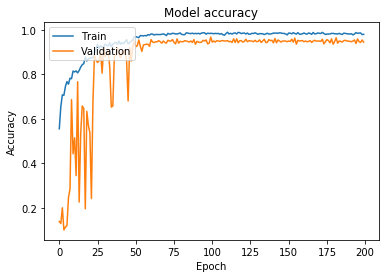

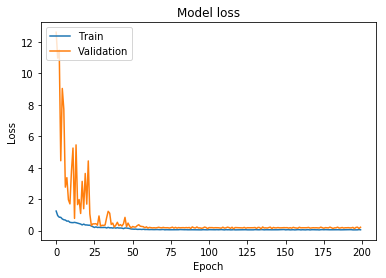

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
Y_pred = model.predict_generator(test_generator, sizesOfSet[2] // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('\tConfusion Matrix')
conf = confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('\n\t\t\tClassification Report')
report = classification_report(test_generator.classes, y_pred, target_names=class_list)
report_dict = classification_report(test_generator.classes, y_pred, target_names=class_list, output_dict = True)
print(report)
print("\n-- Evaluate --")
scores = model.evaluate_generator(test_generator)
under = 1-report_dict['ok']['precision']
over = 1-report_dict['ok']['recall']
print("%s: %.2f\t%s: %.2f%%\n과검율: %.2f%%\t 미검율: %.2f%%"
      %(model.metrics_names[0], scores[0], model.metrics_names[1], scores[1]*100,
        over*100, under*100))

	Confusion Matrix
[[124   0   0   1   0   2   1]
 [  1  61   2   0   0   0  10]
 [  1   0 223   0   0   0   1]
 [  0   0   0  69   0   0   0]
 [  0   0   3   0  15   0   0]
 [  1   0   1   0   0  87   0]
 [  0   8   3   0   1   0  43]]

			Classification Report
               precision    recall  f1-score   support

         dent       0.98      0.97      0.97       128
discoloration       0.88      0.82      0.85        74
           ok       0.96      0.99      0.98       225
        other       0.99      1.00      0.99        69
      scratch       0.94      0.83      0.88        18
         sink       0.98      0.98      0.98        89
    substance       0.78      0.78      0.78        55

    micro avg       0.95      0.95      0.95       658
    macro avg       0.93      0.91      0.92       658
 weighted avg       0.94      0.95      0.94       658


-- Evaluate --
loss: 0.18	acc: 94.53%
과검율: 0.89%	 미검율: 3.88%


In [10]:
error_truth = list()
error_count = list()
error_pred = list()
count = 0
for i in range(len(y_pred)):
    if i>0 :
        if test_generator.classes[i-1]!=test_generator.classes[i]:
            count = 0
    if(test_generator.classes[i]!=y_pred[i]):
        error_truth += [test_generator.classes[i]]
        error_count += [count]
        error_pred += [y_pred[i]]
    count += 1

In [11]:
underImageList = list()
for i in range(len(class_list)):
    lgc_file = glob(test_path + '/' + class_list[i] + '/*.jpg')
    for j in range(len(error_truth)):
        if i==error_truth[j] :
#             print('Truth: ')
#             print(class_list[error_truth[j]])
#             print('Predicted as: ')
#             print(class_list[error_pred[j]])
#             display(Image(filename=lgc_file[error_count[j]]) )
            if error_pred[j]==2 :
                underImageList.append(lgc_file[error_count[j]])

In [12]:
underImageList

['/home/mywork/kijun_kwon/data_split1/test/discoloration/DDMQL06S_20171225111523_05_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/discoloration/DDMQJ10S_20171026043929_08_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/scratch/DDMRA08S_20180123101328_11_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/scratch/DDMQL27S_20180111142451_12_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/scratch/DDMRB11S_20180303093515_08_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/sink/DDMQL12S_20171229140534_07_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/substance/DDMQK07S_20171123234046_02_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/substance/DDMQK30S_20171220000043_03_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/substance/DDMQK15S_20171203151901_04_BOTTOM.jpg']